Most of the concepts and code are from https://dspillustrations.com/pages/posts/misc/python-ofdm-example.html

# **Import libraries**

In [1]:
import cv2
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import requests
import urllib.request
import scipy
from scipy import interpolate
from skimage import io
# from google.colab.patches import cv2_imshow
from scipy.ndimage import gaussian_filter1d
import scipy.fftpack
import math as math

# **Define Function**

***Miscellaneous Function***

In [2]:
def xor(a, b): 
   
    # initialize result 
    result = [] 
   
    # same, then XOR is 0, else 1 
    for i in range(1, len(b)): 
        if a[i] == b[i]: 
            result.append('0') 
        else: 
            result.append('1') 
   
    return ''.join(result) 

def covturl(urls):
    resp = requests.get(urls, stream=True).raw
    imgg = np.asarray(bytearray(resp.read()), dtype="uint8")
    return imgg

def mod2div(divident, divisor): 
    # Number of bits to be XORed at a time. 
    pick = len(divisor) 
   
    # Slicing the divident to appropriate 
    # length for particular step 
    tmp = divident[0 : pick] 
   
    while pick < len(divident): 
   
        if tmp[0] == '1': 
   
            # replace the divident by the result 
            # of XOR and pull 1 bit down 
            tmp = xor(divisor, tmp) + divident[pick] 
   
        else:   # If leftmost bit is '0' 
  
            # If the leftmost bit of the dividend (or the 
            # part used in each step) is 0, the step cannot 
            # use the regular divisor; we need to use an 
            # all-0s divisor. 
            tmp = xor('0'*pick, tmp) + divident[pick] 
   
        # increment pick to move further 
        pick += 1
   
    # For the last n bits, we have to carry it out 
    # normally as increased value of pick will cause 
    # Index Out of Bounds. 
    if tmp[0] == '1': 
        tmp = xor(divisor, tmp) 
    else: 
        tmp = xor('0'*pick, tmp) 
   
    checkword = tmp 
    return checkword 

def encodeData(data, key):
    l_key = len(key) 
   
    # Appends n-1 zeroes at end of data 
    appended_data = data + '0'*(l_key-1) 
    remainder = mod2div(appended_data, key) 
   
    # Append remainder in the original data 
    codeword = data + remainder 
    return codeword     

def decodeData(data, key): 
   
    l_key = len(key) 
   
    # Appends n-1 zeroes at end of data 
    appended_data = data + '0'*(l_key-1) 
    remainder = mod2div(appended_data, key) 
   
    return remainder 

def split(word): 
    return [char for char in word] 

def PS_FIXED(bits):
    return bits.reshape((-1,))

***Channel Function***

In [3]:
def group_bits(bitc):
    bity = []
    x = 0
    for i in range((len(bitc)//payloadBits_per_OFDM)+1):
        bity.append(bitc[x:x+payloadBits_per_OFDM])
        x = x+payloadBits_per_OFDM
    k = i-1
    pp = np.zeros(714, dtype = int)
    bity[-1] = pp
    return bity

def SP(bits):
    return bits.reshape((len(dataCarriers), mu))


def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)


def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # add them to the beginning
 
def channel(signal):
    convolved = np.convolve(signal,channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10) # calculate noise power based on signal power and SNR
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))     
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def removeCP(signal):
    return signal[CP:(CP+K)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

def get_payload(equalized):
    return equalized[dataCarriers]

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def PS(bits):
    return bits.reshape((-1,))

def channelEstimate_FIXED(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)   
    return Hest

def SNR_return(num_snr):
    def channel_V(signal):
        convolved = np.convolve(signal,channelResponse)
        signal_power = np.mean(abs(convolved**2))
        sigma2 = signal_power * 10**(-SNRdb/10) # calculate noise power based on signal power and SNR
        # Generate complex noise with given variance
        noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
        return convolved + noise
    SNR_Array = np.arange(0,num_snr,0.05)
    bitsnr = bitx[10]
    ber = []
    for i in SNR_Array:
        SNRdb = i
        bits_SP = SP(bitsnr)
        QAM = Mapping(bits_SP)
        OFDM_data = OFDM_symbol(QAM)
        OFDM_time = IDFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time)
        OFDM_Tx = OFDM_withCP
        OFDM_Rx = channel_V(OFDM_withCP)
        OFDM_RX_noCP = OFDM_Rx[(CP):(CP+K)]
        OFDM_demod = DFT(OFDM_RX_noCP)
        Hest = channelEstimate_FIXED(OFDM_demod)
        equalized_Hest = equalize(OFDM_demod, Hest)
        QAM_est = get_payload(equalized_Hest)
        PS_est, hardDecision = Demapping(QAM_est)
        bits_est = PS_FIXED(PS_est)
        ber.append(np.sum(abs(bitsnr-bits_est))/len(bitsnr))
    return SNR_Array, ber

def bit_plot(bit_x, a ,b):
    sin_time = []
    #import math as math
    # Number of sample points
    N = 400
    # sample spacing
    T = 1 / 0.32e12
    t = np.linspace(0.0, N*T, N)
    fd = 0
    fc = 24e9
    s = np.zeros(len(t), dtype = float)
    bits_SP = SP(bitx[bit_x])
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time_V = IDFT(OFDM_data)
    for i in OFDM_time_V:
        sin_time.append(abs(i)*np.sin(((2*np.pi)*(fc+fd)*t) + math.atan(i.imag/i.real)))
        fd += 1e9
    for j in range(len(t)):
        for i in sin_time:
            s[j] += i[j]
    plt.plot(t,s)
    plt.grid(True)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude(V)")
    plt.title("OFDM in time-domain")
    plt.show()
    #part2
    for i in range(a,b):
        plt.plot(t, sin_time[i])
        plt.grid(True)
    plt.show()
    #part3
    for i in range(len(sin_time)):
        yf = scipy.fftpack.fft(sin_time[i])
        xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
        plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.grid(True)
    plt.title("OFDM in frequency-domain")
    plt.ylabel("|H(f)|")
    plt.xlabel("Frequency(Hz)")
    plt.show()

    #look closely in 2 frequncies spiked
    # Number of sample points
    sin_time_x = []
    G = 75 #N
    # sample spacing
    M = 1 / 0.0580e12 #T
    O = np.linspace(0.0, G*M, G) #t
    fd = 0
    fc = 24e9
    s = np.zeros(len(O), dtype = float)
    for i in OFDM_time_V:
        sin_time_x.append(abs(i)*np.sin(((2*np.pi)*(fc+fd)*O) + math.atan(i.imag/i.real)))
        fd += 1e9
    for i in range(len(sin_time[0:2])):
        yf = scipy.fftpack.fft(sin_time[i])
        xf = np.linspace(0.0, 1.0/(2.0*M), int(G/2))
        plt.plot(xf, 2.0/G * np.abs(yf[:G//2]))
    plt.grid(True)
    plt.title("OFDM in frequency-domain")
    plt.ylabel("|H(f)|")
    plt.xlabel("Frequency(Hz)")
    plt.show()

def channel_X(signal):
    convolved = np.convolve(signal,channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10) # calculate noise power based on signal power and SNR
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def pro_bits(SNR_X, bit):
    ber = 0
    bit_rx1 = []
    SNRdb = SNR_X
    for i in bit:
        bits_SP = SP(i)
        QAM = Mapping(bits_SP)
        OFDM_data = OFDM_symbol(QAM)
        OFDM_time = IDFT(OFDM_data)
        OFDM_withCP = addCP(OFDM_time)
        OFDM_Tx = OFDM_withCP
        OFDM_Rx = channel_X(OFDM_withCP)
        OFDM_RX_noCP = OFDM_Rx[(CP):(CP+K)]
        OFDM_demod = DFT(OFDM_RX_noCP)
        Hest = channelEstimate_FIXED(OFDM_demod)
        equalized_Hest = equalize(OFDM_demod, Hest)
        QAM_est = get_payload(equalized_Hest)
        PS_est, hardDecision = Demapping(QAM_est)
        bits_est = PS_FIXED(PS_est)
        ber += np.sum(abs(i-bits_est))/len(i)
        bit_rx1.append(bits_est)
    print("Total BER is :" + str(ber / ((len(img_rft)//payloadBits_per_OFDM)+1)))
    print("All frames are sent")
    return bit_rx1


# **Main**

**Sender Part**

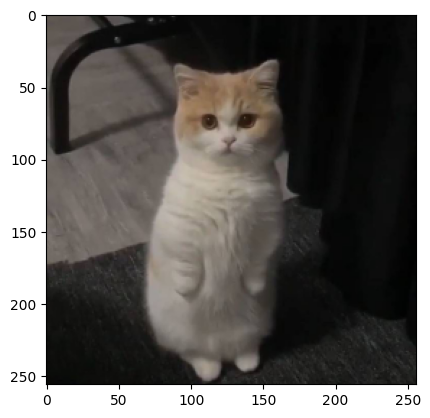

In [4]:
#Drop image url 
# url = input("Enter your url :")
# img = covturl(url)
# img = cv2.imdecode(img,cv2.IMREAD_COLOR)
# img = cv2.imread("./test.bmp", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("./medium.bmp.bmp", cv2.IMREAD_COLOR)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = plt.imread("./medium.bmp")

plt.imshow(img)

In [5]:
#Data preprocessing
#convert img to binary
img_reshape = img.shape[0]*img.shape[1]*img.shape[2]
imgx = img
img = img.reshape(img_reshape)
img_binary = []
for i in img:
    img_binary.append("{0:b}".format(i).zfill(8))

In [6]:
#CRC adder with key "1101
key = "1101"
img_en = []
for i in img_binary:
    img_en.append(encodeData(i, key))

In [7]:
#transmit image
img_en = np.array(img_en)
img_for_trans1 = []
img_ready_for_trans = []

for i in img_en:
    img_for_trans1.append(split(i))
img_for_trans1 = np.vstack(img_for_trans1)

for i in img_for_trans1:
    for j in range(11):
        img_ready_for_trans.append(int(i[j]))
        
img_ready_for_trans = np.array(img_ready_for_trans)
img_rft = img_ready_for_trans

**Channel Part**

[  0  16  32  48  64  80  96 112]
allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers: [  0  16  32  48  64  80  96 112 127]
dataCarriers:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  

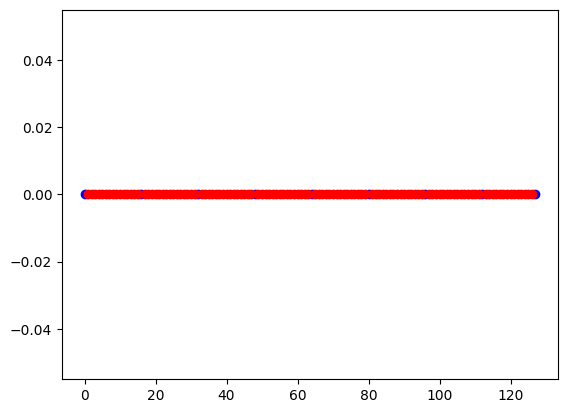

In [8]:
# ## **CHANNEL** ##

# CHANNEL SETTING

#CA
K = 128
CP = K // 4
P = 8                       # number of pilot carriers per OFDM block
pilotValue = 7+7j           # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P]        # Pilots is every (K/P)th carrier.
print(pilotCarriers)

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

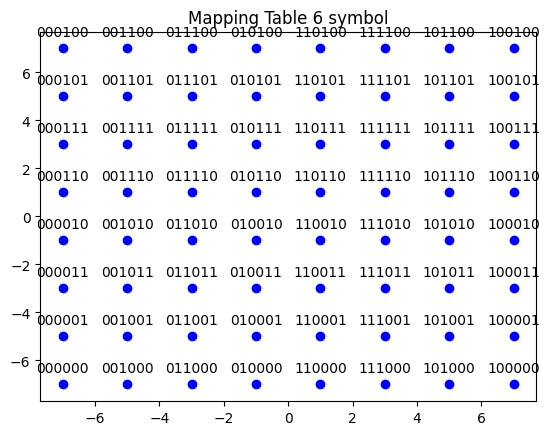

In [9]:
mu = 6 # bits per symbol (64QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0,0,0) : -7-7j,
    (0,0,0,0,0,1) : -7-5j,
    (0,0,0,0,1,1) : -7-3j,
    (0,0,0,0,1,0) : -7-1j,
    (0,0,0,1,1,0) : -7+1j,
    (0,0,0,1,1,1) : -7+3j,
    (0,0,0,1,0,1) : -7+5j,
    (0,0,0,1,0,0) : -7+7j,
    (0,0,1,1,0,0) : -5+7j,
    (0,0,1,1,0,1) : -5+5j,
    (0,0,1,1,1,1) : -5+3j,
    (0,0,1,1,1,0) : -5+1j,
    (0,0,1,0,1,0) : -5-1j,
    (0,0,1,0,1,1) : -5-3j,
    (0,0,1,0,0,1) : -5-5j,
    (0,0,1,0,0,0) : -5-7j,
    (0,1,1,0,0,0) : -3-7j,
    (0,1,1,0,0,1) : -3-5j,
    (0,1,1,0,1,1) : -3-3j,
    (0,1,1,0,1,0) : -3-1j,
    (0,1,1,1,1,0) : -3+1j,
    (0,1,1,1,1,1) : -3+3j,
    (0,1,1,1,0,1) : -3+5j,
    (0,1,1,1,0,0) : -3+7j,
    (0,1,0,1,0,0) : -1+7j,
    (0,1,0,1,0,1) : -1+5j,
    (0,1,0,1,1,1) : -1+3j,
    (0,1,0,1,1,0) : -1+1j,
    (0,1,0,0,1,0) : -1-1j,
    (0,1,0,0,1,1) : -1-3j,
    (0,1,0,0,0,1) : -1-5j,
    (0,1,0,0,0,0) : -1-7j,
    (1,1,0,0,0,0) : 1-7j,
    (1,1,0,0,0,1) : 1-5j,
    (1,1,0,0,1,1) : 1-3j,
    (1,1,0,0,1,0) : 1-1j,
    (1,1,0,1,1,0) : 1+1j,
    (1,1,0,1,1,1) : 1+3j,
    (1,1,0,1,0,1) : 1+5j,
    (1,1,0,1,0,0) : 1+7j,
    (1,1,1,1,0,0) : 3+7j,
    (1,1,1,1,0,1) : 3+5j,
    (1,1,1,1,1,1) : 3+3j,
    (1,1,1,1,1,0) : 3+1j,
    (1,1,1,0,1,0) : 3-1j,
    (1,1,1,0,1,1) : 3-3j,
    (1,1,1,0,0,1) : 3-5j,
    (1,1,1,0,0,0) : 3-7j,
    (1,0,1,0,0,0) : 5-7j,
    (1,0,1,0,0,1) : 5-5j,
    (1,0,1,0,1,1) : 5-3j,
    (1,0,1,0,1,0) : 5-1j,
    (1,0,1,1,1,0) : 5+1j,
    (1,0,1,1,1,1) : 5+3j,
    (1,0,1,1,0,1) : 5+5j,
    (1,0,1,1,0,0) : 5+7j,
    (1,0,0,1,0,0) : 7+7j,
    (1,0,0,1,0,1) : 7+5j,
    (1,0,0,1,1,1) : 7+3j,
    (1,0,0,1,1,0) : 7+1j,
    (1,0,0,0,1,0) : 7-1j,
    (1,0,0,0,1,1) : 7-3j,
    (1,0,0,0,0,1) : 7-5j,
    (1,0,0,0,0,0) : 7-7j,
}
for d5 in [0,1]:
    for d4 in [0,1]:
        for d3 in [0,1]:
            for d2 in [0,1]:
                for d1 in [0,1]:
                    for d0 in [0,1]:
                        D = (d5,d4,d3,d2,d1,d0)
                        Q = mapping_table[D]
                        plt.title("Mapping Table 6 symbol")
                        plt.plot(Q.real,Q.imag, 'bo')
                        plt.text(Q.real,Q.imag+0.5, "".join(str(x) for x in D), ha = 'center')

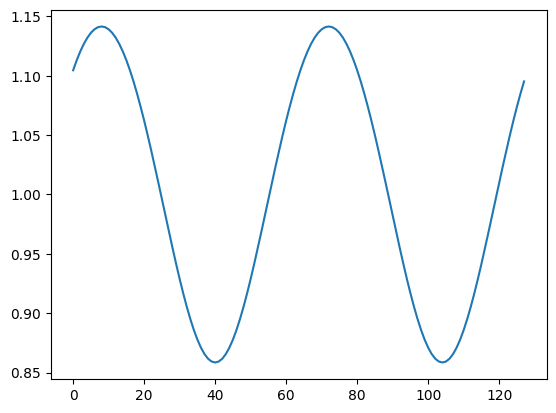

In [10]:
bitx = group_bits(img_rft)
## in this part, we demonstate selecting only 1 frame to send. ##

demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1,0,0.1+0.1j]) # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

In [11]:
SNRdb = 25# signal to noise-ratio in dB at the receiver
#S/P
bits = np.array(bitx[2]) #we select frame 2 to send
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])
print("\n")

First 5 bit groups
[[0 1 0 1 0 1]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [1 0 1 0 1 1]
 [0 1 0 1 1 1]]




In [12]:
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[0 1 0 1 0 1]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [1 0 1 0 1 1]
 [0 1 0 1 1 1]]
[-1.+5.j -1.+5.j  5.-1.j  5.-3.j -1.+3.j]


In [13]:
OFDM_data = OFDM_symbol(QAM)
OFDM_time = IDFT(OFDM_data)
OFDM_withCP = addCP(OFDM_time)

print("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
print("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM carriers in frequency domain:  128
Number of OFDM samples in time-domain before CP:  128
Number of OFDM samples in time domain with CP:  160


RX Signal power: 0.4031. Noise power: 0.0013


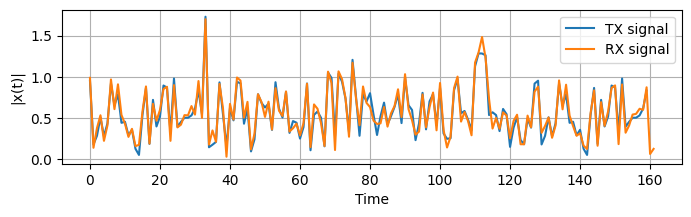

In [14]:
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel("Time") 
plt.ylabel("|x(t)|")
plt.grid(True);


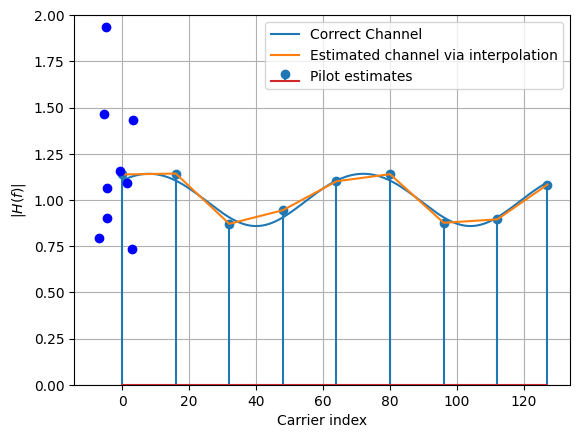

In [15]:
OFDM_RX_noCP = removeCP(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
print("\n")
Hest = channelEstimate(OFDM_demod)
equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo', scalex = True, scaley = True);

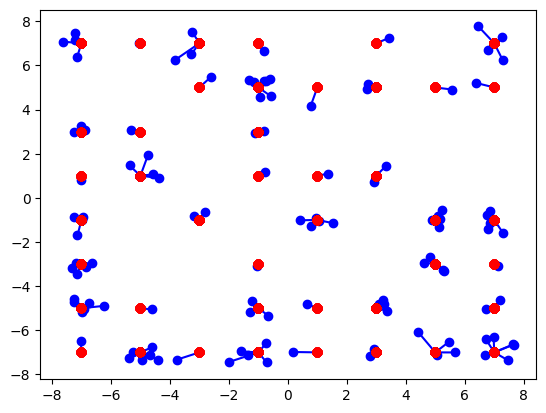

In [16]:
PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [17]:
bits_est = PS(PS_est)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.0056022408963585435


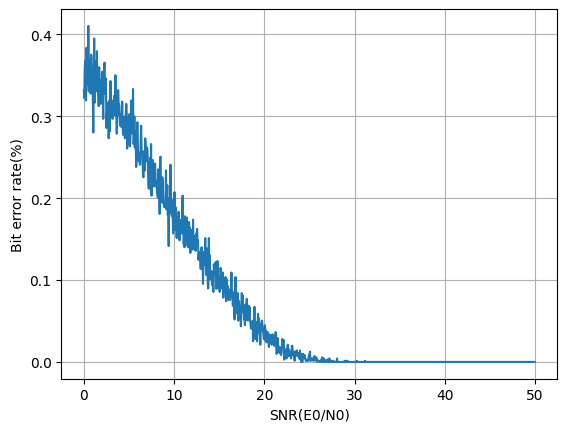

In [18]:
SNR_fp, ber_fp = SNR_return(50)
plt.plot(SNR_fp, ber_fp)
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
plt.show()


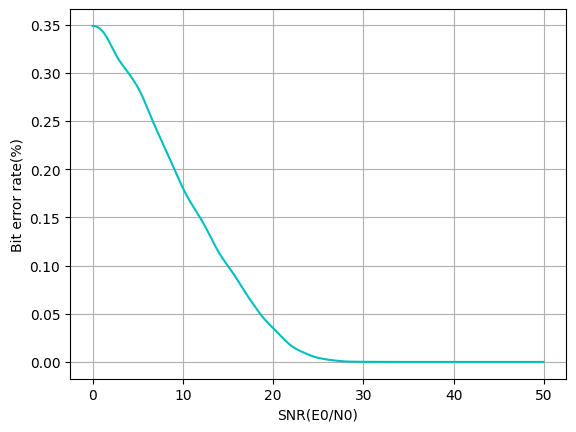

In [19]:
ysmoothed = gaussian_filter1d(ber_fp, sigma=15)
plt.plot(SNR_fp, ysmoothed, 'c')
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
plt.show()

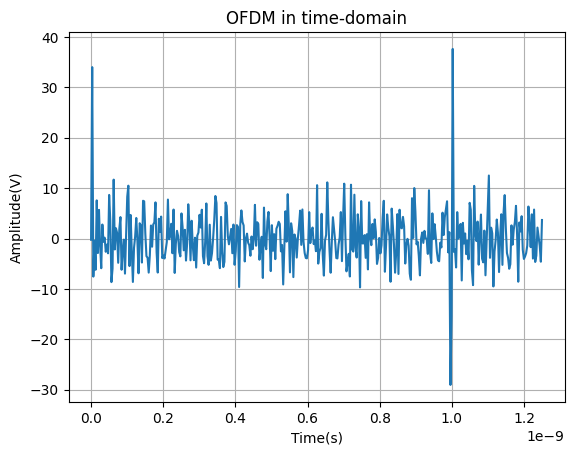

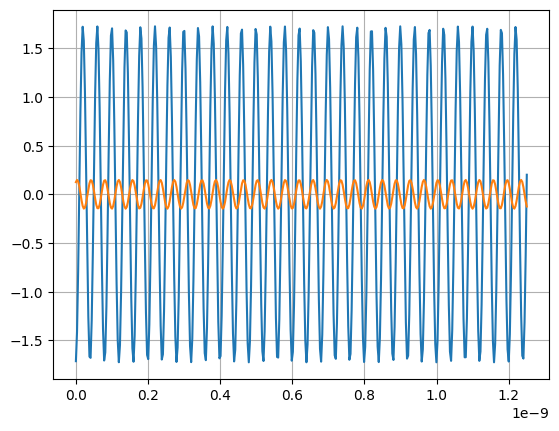

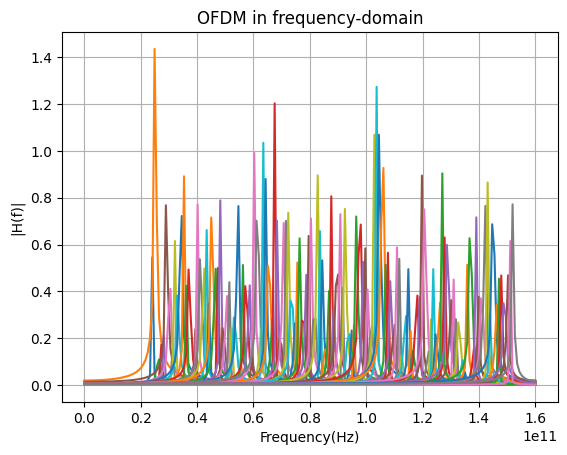

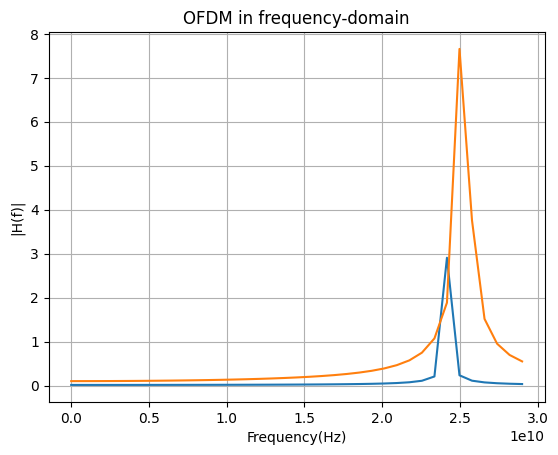

In [20]:
## The expression of wave in time domain & frequency domain
bit_plot(2, 1, 3)

**Receiver Part**

In [21]:
SNR = 1 #Change to adjust channel quaility
bit_rx = pro_bits(SNR, bitx)

bit_rx = np.array(bit_rx)
img_fr = []
img_rfr = []
for i in bit_rx:
  img_fr.append(split(i))
img_fr = np.vstack(img_fr)

img_rfr = []
for i in img_fr:
    for j in range(len(img_fr[:2][1])):
        img_rfr.append(int(i[j]))
img_rfr = np.array(img_rfr)

img_rfr1 = []
for i in range(len(img_rft)):
    x = img_rfr[i]
    img_rfr1.append(x)
img_rfr1 = np.array(img_rfr1)

img_rea = []
k = 0
for i in range(len(img_rfr1)):
    img_rea.append(img_rfr1[k:k+11])
    k+=11
    
img_done = []
for i in img_rea[:]:
    x = []
    for j in range(len(i)):
        x.append(str(i[j]))
    img_done.append(x)

sep = ''
img_fin = []
for i in img_done:
    img_fin.append(sep.join(i))

Total BER is :0.0023822008169395114
All frames are sent


In [22]:
#remove CRC and compare
img_crc = []
for i in img_fin:
    img_crc.append(decodeData(i, key))

count = 0
for i in img_crc:
    if i != '000':
        if i!= '00':
            count += 1

print("Amount of total bits: %10d" %(len(img_rft)))
print("Amount of error bit(s): %4d" %count)

Amount of total bits:    2162688
Amount of error bit(s): 4954


In [23]:
#decode
img_dec = []
for i in img_fin:
    img_dec.append(i[0:8])
img_dec = np.array(img_dec)


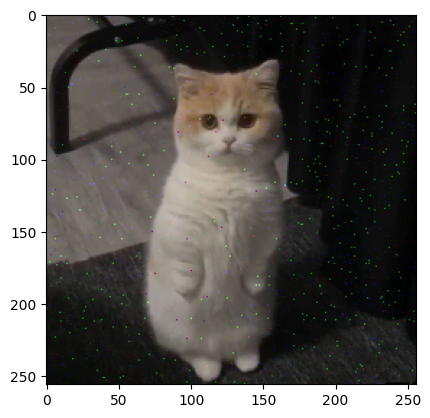

In [24]:
##We can change SNR to see another quality of the image after passing the channel 
img_back = []
for i in range(len(img_binary)):
    img_back.append(int(img_dec[i],2))
img_back = np.array(img_back)
img_back = img_back.reshape(imgx.shape[0], imgx.shape[1], imgx.shape[2])
plt.imshow(img_back)